In [ ]:
# STEP 1: Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [ ]:
# STEP 2: Loading the Dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# STEP 3: Preprocessing the Data
# Drop customerID
df.drop('customerID', axis=1, inplace=True)

# Converting TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Encoding target variable
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Encoding categorical variables
categorical = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical:
    df[col] = le.fit_transform(df[col])


<ipython-input-5-3165047859>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


In [ ]:
# STEP 4: Spliting Features and Target
X = df.drop('Churn', axis=1)
y = df['Churn']

In [ ]:
# STEP 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# STEP 6: Scaling Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# STEP 7: Applying SMOTE to Balance the Dataset
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_resampled).value_counts().to_dict())

Before SMOTE: {0: 4139, 1: 1495}
After SMOTE: {0: 4139, 1: 4139}


In [ ]:
# STEP 8: Training a RandomForestClassifier on Balanced Data
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)


RandomForestClassifier(random_state=42)


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1035
           1       0.57      0.58      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409



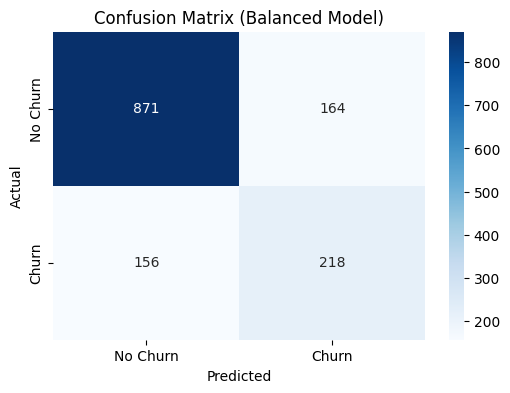

In [ ]:
# STEP 9: Predicting on Test Set
y_pred = model.predict(X_test)

# STEP 10: Evaluating Model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix (Balanced Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


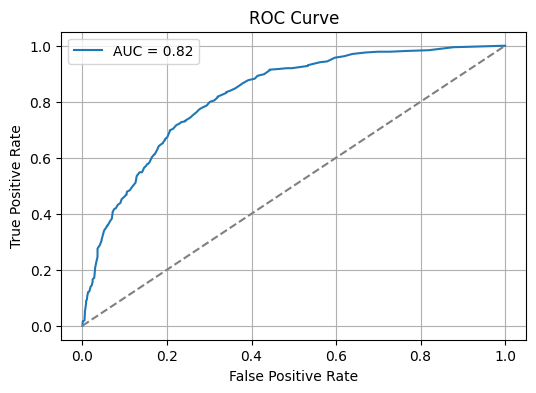

In [ ]:
# STEP 11: Ploting the ROC Curve
y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()



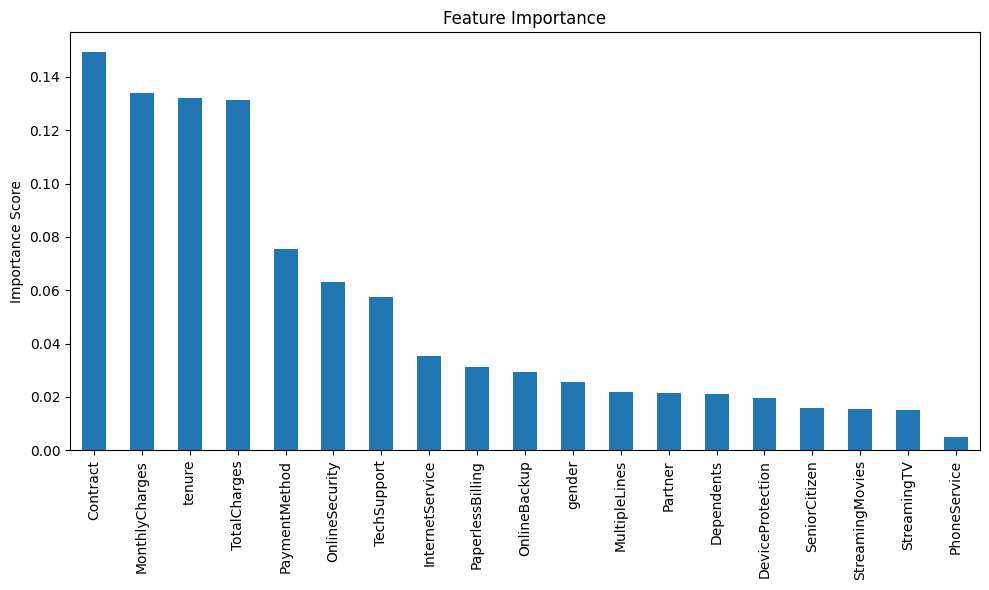

In [ ]:
# STEP 12: Feature Importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='bar', figsize=(10,6))
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
# STEP 13: Identifing At-Risk Customers Based on Churn Probability
threshold = 0.7
churn_probs = model.predict_proba(X_test)[:, 1]

# Get original customer data for X_test (before scaling)
X_test_original = pd.DataFrame(scaler.inverse_transform(X_test), columns=X.columns)
X_test_original['Churn_Prob'] = churn_probs
X_test_original['Predicted_Churn'] = model.predict(X_test)

# Filtering customers with high churn risk
at_risk_customers = X_test_original[X_test_original['Churn_Prob'] > threshold]

In [ ]:
# STEP 14: Suggesting Retention Actions
def suggest_retention_action(row):
    actions = []
    if row['MonthlyCharges'] > 80:
        actions.append("Offer discount on monthly plan")
    if row['Contract'] == 0:  # Encoded as 0 (Month-to-month)
        actions.append("Promote long-term contract benefits")
    if row['TechSupport'] == 0:  # No tech support
        actions.append("Offer free tech support trial")
    if row['InternetService'] == 0:  # DSL (usually slower)
        actions.append("Upgrade to faster internet")
    if row['tenure'] < 6:
        actions.append("Send welcome loyalty rewards")
    return ", ".join(actions)

at_risk_customers['Retention_Strategy'] = at_risk_customers.apply(suggest_retention_action, axis=1)




<ipython-input-22-2251560315>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  at_risk_customers['Retention_Strategy'] = at_risk_customers.apply(suggest_retention_action, axis=1)


In [ ]:
# STEP 15: Save or Display At-Risk Customers with Suggestions
print("\n At-Risk Customers with Suggested Retention Actions:")
print(at_risk_customers[['MonthlyCharges', 'Contract', 'TechSupport', 'tenure', 'Churn_Prob', 'Retention_Strategy']].head())



 At-Risk Customers with Suggested Retention Actions:
    MonthlyCharges  Contract  TechSupport  tenure  Churn_Prob  \
1           100.15       0.0          2.0     8.0        0.79   
13           84.80       0.0          0.0    11.0        0.76   
20           74.85       0.0          0.0     2.0        0.71   
29           89.45       0.0          0.0     3.0        0.77   
34           90.40       0.0          0.0     2.0        0.96   

                                   Retention_Strategy  
1   Offer discount on monthly plan, Promote long-t...  
13  Offer discount on monthly plan, Promote long-t...  
20  Promote long-term contract benefits, Offer fre...  
29  Offer discount on monthly plan, Promote long-t...  
34  Offer discount on monthly plan, Promote long-t...  


In [ ]:
# STEP 16: Train model without SMOTE
model_no_smote = RandomForestClassifier(random_state=42)
model_no_smote.fit(X_train, y_train)
y_pred_no_smote = model_no_smote.predict(X_test)

# Evaluation
print(" Without SMOTE:")
print(classification_report(y_test, y_pred_no_smote))

# With SMOTE already trained earlier
print("With SMOTE:")
print(classification_report(y_test, y_pred))


⚖️ Without SMOTE:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

🧪 With SMOTE:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1035
           1       0.57      0.58      0.58       374

    accuracy                           0.77      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409



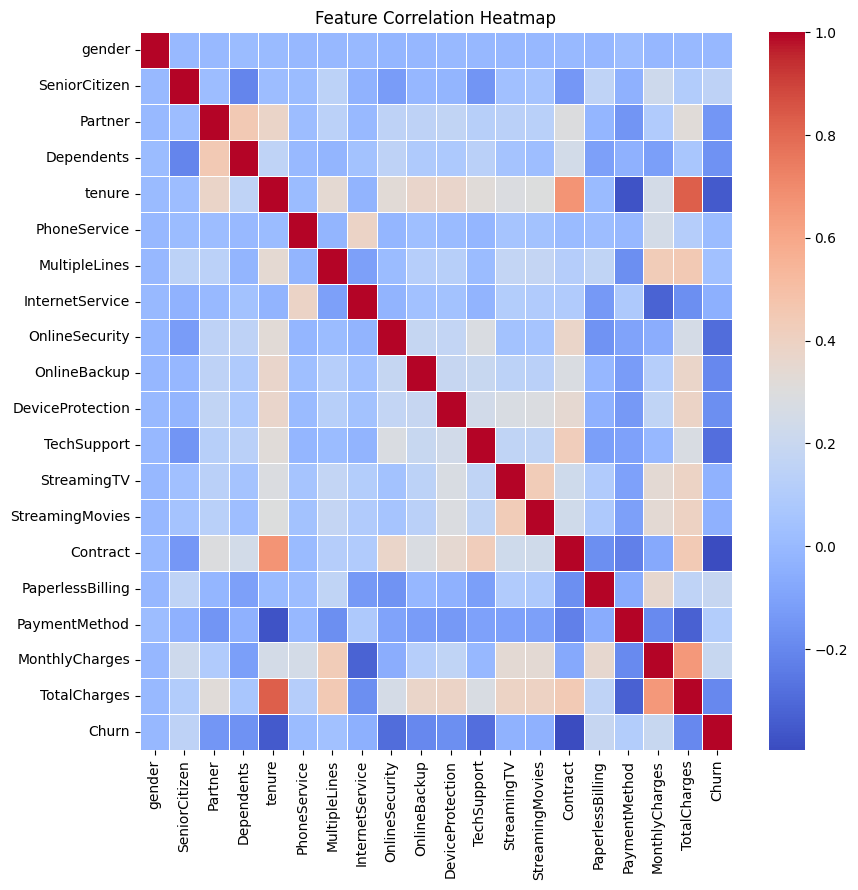

In [ ]:
#  STEP 17: Check multicollinearity between features
plt.figure(figsize=(9,9))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()
